In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Transformer, CRS
from tqdm import tqdm
import numpy as np
from skimage import measure
import numpy as np
from scipy.ndimage import label

# 0. Reproject DEM onto OPERA grid

In [43]:
dem_path = '/work/FAC/FGSE/IDYST/tbeucler/downscaling/fquareng/data/OPERA/dem/europe_1km_dem.nc'

dem_ds = xr.open_dataset(dem_path)
dem_ds.attrs

{'creation_date': '2022-07-16 20:54',
 'title': 'DEM',
 'description': 'Pan-european DEM',
 'grid': 'LAEA',
 'institution': 'NASA & JAXA',
 'source_url': 'https://asterweb.jpl.nasa.gov/gdem.asp',
 'project_name': 'H2020_RethinkAction',
 'project_GA_no': '101037104',
 'project_partner': 'NOA',
 'project_task': 'Task_3.2',
 'xres': '1000 m',
 'yres': '1000 m'}

In [44]:
dem_ds["spatial_ref"].attrs

{'GeoTransform': '139006.03207051056 123086.18634436552 0.0 5907939.833789606 0.0 -123086.18634436552',
 'crs_wkt': 'PROJCS["ETRS89 / LAEA Europe",        GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",        SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],        TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,        AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,        AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],        PROJECTION["Lambert_Azimuthal_Equal_Area"],        PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],        PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],        UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","3035"]]',
 'false_easting': np.float64(4321000.0),
 'false_northing': np.float64(3210000.0),
 'geographic_crs_name': 'ETRS89',
 'grid_mapping_name': 'lambert_azimuthal_equal_area',
 'horizontal_datum_name': 'European Terr

In [45]:
np.min(dem_ds['DEM'].values)

np.float32(nan)

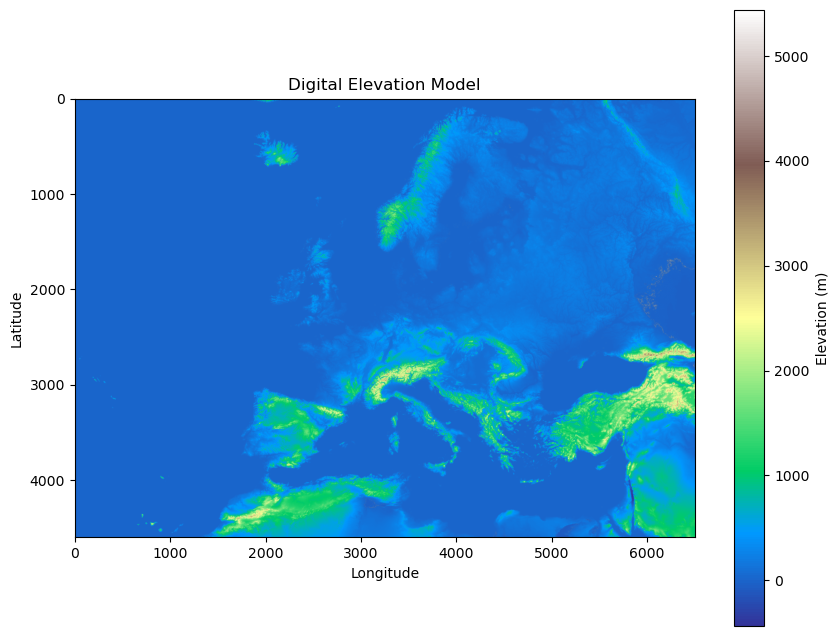

In [7]:
def plot_dem_netcdf(dem_path):
    ds = xr.open_dataset(dem_path)
    dem = ds["DEM"]

    plt.figure(figsize=(10, 8))
    plt.imshow(dem[::-1, :], origin='upper', cmap='terrain')

    plt.colorbar(label='Elevation (m)')
    plt.title('Digital Elevation Model')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

plot_dem_netcdf(dem_path)

In [8]:
base_path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/raw_data/OPERA"
date_folders = sorted(os.listdir(base_path))

datasets = []
for d in tqdm(date_folders):
    ds = xr.open_zarr(os.path.join(base_path, d), chunks={})  # chunks={} triggers lazy loading
    datasets.append(ds)

precip_ds = xr.concat(datasets, dim="time")
precip_ds 

100%|██████████| 435/435 [00:29<00:00, 14.86it/s]


<xarray.Dataset> Size: 1TB
Dimensions:   (time: 41575, y: 2200, x: 1900)
Coordinates:
  * time      (time) datetime64[ns] 333kB 2023-08-01 ... 2024-10-30T12:15:00
  * x         (x) float64 15kB -0.0002454 2.001e+03 ... 3.798e+06 3.8e+06
  * y         (y) float64 18kB -4.4e+06 -4.398e+06 ... -2.001e+03 -0.0004263
Data variables:
    TOT_PREC  (time, y, x) float64 1TB dask.array<chunksize=(1, 2200, 1900), meta=np.ndarray>

In [24]:
def plot_prec(ds, dem_ds, i, title):

    # Your custom LAEA projection string (used in OPERA, close to EPSG:3035)
    laea_proj = CRS.from_proj4("+proj=laea +lat_0=55 +lon_0=10 +x_0=1950000 +y_0=-2100000 +units=m +datum=WGS84 +no_defs")

    dem_laea_proj = CRS.from_proj4("+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000 +y_0=3210000 +units=m +datum=WGS84 +no_defs")

    # Target CRS (WGS 84)
    target = CRS.from_epsg(3857) # 4326, 3857

    # Set up transformer
    transformer = Transformer.from_crs(laea_proj, target, always_xy=True)
    transformer_dem = Transformer.from_crs(dem_laea_proj, target, always_xy=True)

    # Grid arrays
    x = ds['x'].to_numpy()        # shape (1900,)
    y = ds['y'].to_numpy()[::-1]  # flip y to match north-up orientation
    # time = ds['time'].to_numpy()[i]
    precip = ds['TOT_PREC'][i].to_numpy()[::-1, :]
    X, Y = np.meshgrid(x, y)
    lon, lat = transformer.transform(X, Y)

    # For DEM
    dem_x = dem_ds['x'].to_numpy()
    dem_y = dem_ds['y'].to_numpy()[::-1]  # flip y
    dem = dem_ds['DEM'].to_numpy()[::-1, :]  # flip y
    dem_X, dem_Y = np.meshgrid(dem_x, dem_y)
    dem_lon, dem_lat = transformer_dem.transform(dem_X, dem_Y)

    _, ax = plt.subplots(figsize=(15, 15), subplot_kw={'projection': ccrs.Mercator()}) # Mercator, Mercator
    im = ax.pcolormesh(lon, lat, precip, transform=ccrs.Mercator(), cmap='viridis', shading='auto')
    im_dem = ax.pcolormesh(dem_lon, dem_lat, dem, transform=ccrs.Mercator(), cmap='terrain', alpha=0.5)
    # im = ax.pcolormesh(lon, lat, np.log(precip), transform=ccrs.Mercator(), cmap='viridis', shading='auto')

    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS)
    ax.grid(True)
    ax.set_title(f"{title}")

    cbar = plt.colorbar(im, ax=ax, shrink=.6, pad=.02)
    cbar.set_label("Log Precipitation [kg/m²]")

    plt.tight_layout()
    plt.show()

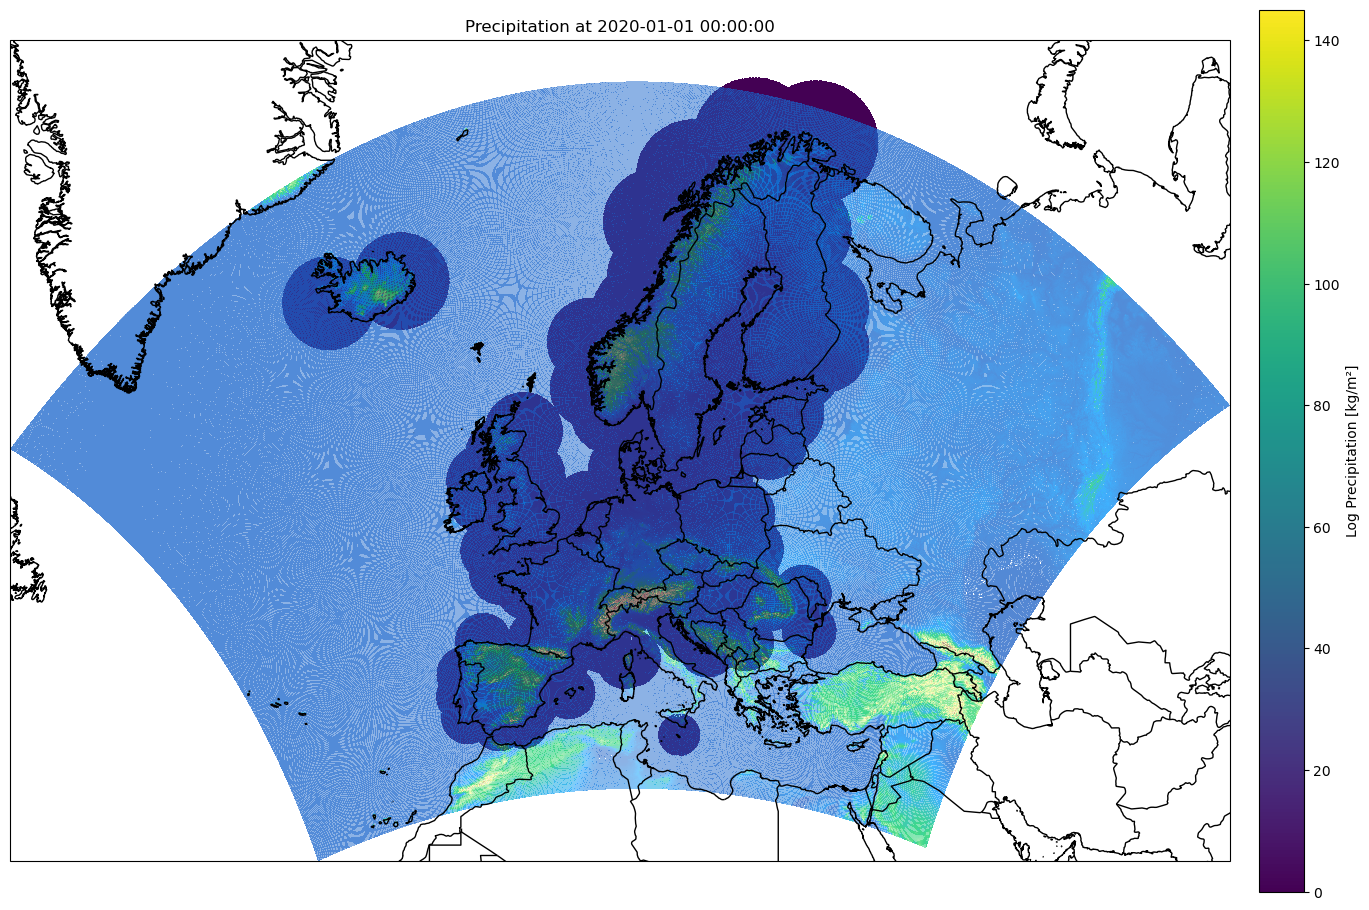

In [25]:
plot_prec(precip_ds, dem_ds, 0, "Precipitation at 2020-01-01 00:00:00")

In [ ]:
import xarray as xr
import rioxarray # Import this for .rio accessor
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import CRS
from rasterio.enums import Resampling # <--- CORRECTED IMPORT!

def plot_prec_with_extended_dem(ds_precip, ds_dem, i, title, fill_value=0.0):
    """
    Plots precipitation data and elevation data. The DEM data is extended
    with a fill_value (e.g., 0 for sea level) where it does not cover the
    precipitation data's extent, specifically north of Norway. Both datasets
    are reprojected to Mercator for plotting.

    Args:
        ds_precip (xr.Dataset): Xarray Dataset containing precipitation data
                                (original custom LAEA projection).
        ds_dem (xr.Dataset): Xarray Dataset containing DEM data (original EPSG:3035).
        i (int): Time index for precipitation data.
        title (str): Title for the plot.
        fill_value (float): Value to fill the DEM where it's missing, e.g., 0.0 for sea level.
    """

    # --- Define CRSs and Transformer ---
    # Precipitation's original custom LAEA CRS
    precip_original_crs_str = "+proj=laea +lat_0=55 +lon_0=10 +x_0=1950000 +y_0=-2100000 +units=m +datum=WGS84 +no_defs"
    
    # DEM's original CRS (EPSG:3035) - Use explicit parameters for Cartopy, EPSG string for rioxarray
    dem_crs_epsg = "EPSG:3035"
    dem_crs_params = {
        'central_latitude': 52.0,
        'central_longitude': 10.0,
        'false_easting': 4321000.0,
        'false_northing': 3210000.0,
        'globe': ccrs.Globe(datum='ETRS89', ellipse='GRS80')
    }
    
    # Target CRS for plotting (Mercator)
    target_mercator_crs_epsg = "EPSG:3857"
    cartopy_plot_crs = ccrs.Mercator() # For Cartopy axis and transform


    print(f"DEM is expected in: {dem_crs_epsg}")
    print(f"Precipitation is expected in: {precip_original_crs_str}")

    # --- 1. Load and prepare DEM data ---
    try:
        dem_data_var = ds_dem["DEM"].rio.set_spatial_dims(x_dim="x", y_dim="y").rio.write_crs(dem_crs_epsg, inplace=True)
        
        # Ensure DEM y-axis is north-up for consistent array access later
        if dem_data_var.y.values[0] > dem_data_var.y.values[-1]:
            dem_data_var = dem_data_var.isel(y=slice(None, None, -1))
            
        print(f"Original DEM bounds ({dem_crs_epsg} m): {dem_data_var.rio.bounds()}")

    except Exception as e:
        print(f"Error loading or preparing DEM: {e}")
        return

    # --- 2. Prepare Precipitation data and reproject to DEM's CRS/grid ---
    try:
        precip_data_var = ds_precip['TOT_PREC'].isel(time=i)
        precip_data_var = precip_data_var.rio.set_spatial_dims(x_dim="x", y_dim="y").rio.write_crs(precip_original_crs_str, inplace=True)
        
        # Ensure precip y-axis is north-up before reprojection
        if precip_data_var.y.values[0] > precip_data_var.y.values[-1]:
            precip_data_var = precip_data_var.isel(y=slice(None, None, -1))
            
        print(f"Original Precipitation bounds (custom LAEA m): {precip_data_var.rio.bounds()}")

        # Reproject precipitation to match DEM's CRS and grid
        precip_reprojected_to_dem_crs = precip_data_var.rio.reproject(
            dem_crs_epsg,
            resampling=Resampling.nearest
        )
        print(f"Reprojected Precipitation bounds ({dem_crs_epsg} m): {precip_reprojected_to_dem_crs.rio.bounds()}")
        print(f"Reprojected Precipitation shape: {precip_reprojected_to_dem_crs.shape}")

    except Exception as e:
        print(f"Error reprojecting precipitation: {e}")
        print("This might mean the precipitation dataset doesn't have valid spatial information or there's no overlap.")
        return

    # --- Step 2 (continued): Create a combined extent and grid and extend DEM ---
    # Determine the combined min/max X/Y from both datasets (in EPSG:3035)
    precip_minx, precip_miny, precip_maxx, precip_maxy = precip_reprojected_to_dem_crs.rio.bounds()
    dem_minx, dem_miny, dem_maxx, dem_maxy = dem_data_var.rio.bounds()

    combined_minx = min(precip_minx, dem_minx)
    combined_miny = min(precip_miny, dem_miny)
    combined_maxx = max(precip_maxx, dem_maxx)
    combined_maxy = max(precip_maxy, dem_maxy)

    # Calculate a resolution based on the DEM, or a consistent resolution
    dem_x_res = dem_data_var.rio.resolution()[0]
    dem_y_res = abs(dem_data_var.rio.resolution()[1])

    # Create new coordinates for the combined grid (in EPSG:3035)
    new_x_coords = np.arange(combined_minx, combined_maxx + dem_x_res, dem_x_res)
    new_y_coords = np.arange(combined_miny, combined_maxy + dem_y_res, dem_y_res)

    # Create a dummy DataArray for the target grid to match.
    target_grid_da = xr.DataArray(
        data=np.empty((len(new_y_coords), len(new_x_coords))),
        coords={'y': new_y_coords, 'x': new_x_coords},
        dims=['y', 'x'],
        attrs=dem_data_var.attrs
    ).rio.write_crs(dem_crs_epsg)

    # Reproject the original DEM onto this larger, combined grid
    extended_dem_data = dem_data_var.rio.reproject_match(target_grid_da, resampling=Resampling.nearest) # <--- CORRECTED HERE
    
    # Fill NaN values (where DEM is missing, likely sea) with the specified fill_value
    extended_dem_data = extended_dem_data.fillna(fill_value)


    # --- Step 3: Reproject both to Mercator for plotting ---
    # Reproject the extended DEM to Mercator
    dem_reprojected_to_mercator = extended_dem_data.rio.reproject(
        target_mercator_crs_epsg,
        resampling=Resampling.nearest # <--- CORRECTED HERE
    )

    # Reproject the original precipitation (still from its *original* variable) to Mercator
    precip_reprojected_to_mercator = precip_data_var.rio.reproject(
        target_mercator_crs_epsg,
        resampling=Resampling.nearest # <--- CORRECTED HERE
    )
    
    # Take log of precipitation data
    precip_log_data_mercator = np.log(precip_reprojected_to_mercator.values + 1e-6)

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'projection': cartopy_plot_crs})

    # Plot extended DEM
    im_dem = ax.pcolormesh(
        dem_reprojected_to_mercator.x.values,
        dem_reprojected_to_mercator.y.values,
        dem_reprojected_to_mercator.values,
        transform=cartopy_plot_crs,
        cmap='terrain',
        shading='auto',
        zorder=1
    )
    cbar_dem = plt.colorbar(im_dem, ax=ax, shrink=.6, pad=.08)
    cbar_dem.set_label("Elevation (m)")

    # Plot precipitation
    im_precip = ax.pcolormesh(
        precip_reprojected_to_mercator.x.values,
        precip_reprojected_to_mercator.y.values,
        precip_log_data_mercator,
        transform=cartopy_plot_crs,
        cmap='viridis',
        shading='auto',
        alpha=0.6,
        zorder=2
    )
    cbar_precip = plt.colorbar(im_precip, ax=ax, shrink=.6, pad=.02)
    cbar_precip.set_label("Log Precipitation [kg/m²]")

    # --- Map Features ---
    ax.coastlines(resolution='10m', zorder=3)
    ax.add_feature(cfeature.BORDERS, zorder=3)
    # ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none', zorder=0)
    # ax.add_feature(cfeature.OCEAN, zorder=0)
    # ax.add_feature(cfeature.LAKES, alpha=0.5, zorder=3)
    # ax.add_feature(cfeature.RIVERS, zorder=3)

    # Set map extent to encompass the entire reprojected precipitation data (or the combined extent)
    combined_merc_minx = min(dem_reprojected_to_mercator.x.min().item(), precip_reprojected_to_mercator.x.min().item())
    combined_merc_maxx = max(dem_reprojected_to_mercator.x.max().item(), precip_reprojected_to_mercator.x.max().item())
    combined_merc_miny = min(dem_reprojected_to_mercator.y.min().item(), precip_reprojected_to_mercator.y.min().item())
    combined_merc_maxy = max(dem_reprojected_to_mercator.y.max().item(), precip_reprojected_to_mercator.y.max().item())

    ax.set_xlim(combined_merc_minx, combined_merc_maxx)
    ax.set_ylim(combined_merc_miny, combined_merc_maxy)

    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    ax.set_title(f"{title} (Precipitation at {ds_precip['time'].to_numpy()[i]})")

    plt.tight_layout()
    plt.show()

# --- Example Usage (assuming you've loaded your datasets as ds_precip and ds_dem) ---
# dem_path = '/work/FAC/FGSE/IDYST/tbeucler/downscaling/fquareng/data/OPERA/dem/europe_1km_dem.nc'
# precip_data_path = '/path/to/your/opera_precipitation_data.nc' # REMEMBER TO UPDATE THIS

# try:
#     # Assuming ds_precip and ds_dem are already loaded outside the function call
#     # For example:
#     # ds_precip = xr.open_dataset(precip_data_path)
#     # ds_dem = xr.open_dataset(dem_path)

#     plot_prec_with_extended_dem(
#         ds_precip=ds_precip, # Pass your loaded xarray Dataset
#         ds_dem=ds_dem,       # Pass your loaded xarray Dataset
#         i=0, # First time step
#         title="Extended DEM with OPERA Precipitation (Mercator)",
#         fill_value=0.0 # Fill missing DEM with 0 meters (sea level)
#     )
# except FileNotFoundError as e:
#     print(f"Error: One of the files not found. Please check paths: {e}")
# except Exception as e:
#     print(f"An error occurred: {e}")



DEM is expected in: EPSG:3035
Precipitation is expected in: +proj=laea +lat_0=55 +lon_0=10 +x_0=1950000 +y_0=-2100000 +units=m +datum=WGS84 +no_defs
Original DEM bounds (EPSG:3035 m): (900000.0, 900000.0, 7400000.0, 5500000.0)
Original Precipitation bounds (custom LAEA m): (-1000.5268384402792, -4401000.4558098605, 3801000.526820769, 1000.4543260307499)
Reprojected Precipitation bounds (EPSG:3035 m): (2360534.1240708516, 1225894.0108228181, 6181854.7281258935, 5639419.273935605)
Reprojected Precipitation shape: (2206, 1910)


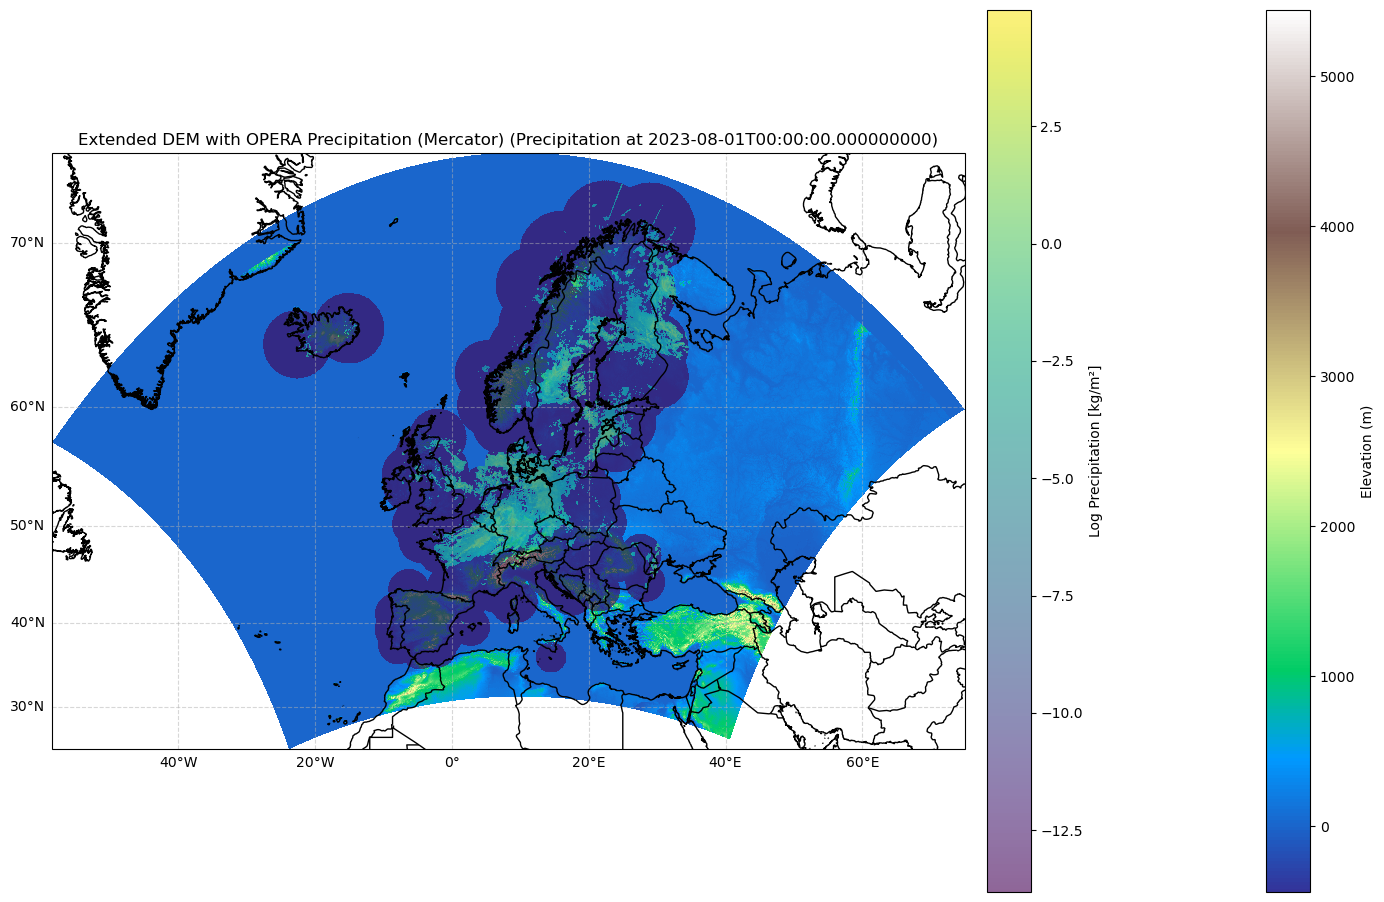

In [47]:
plot_prec_with_extended_dem(
        ds_precip=precip_ds,
        ds_dem=dem_ds,
        i=0, # First time step
        title="Extended DEM with OPERA Precipitation (Mercator)",
        fill_value=0.0 # Fill missing DEM with 0 meters (sea level)
    )

In [ ]:
import xarray as xr
import rioxarray
import numpy as np
from pyproj import CRS
from rasterio.enums import Resampling # Ensure this is imported for resampling

def extend_dem_to_match_precipitation_coverage(ds_dem, ds_precip, precip_time_index=0, fill_value=0.0):
    """
    Extends the DEM data's coverage to encompass the precipitation data's extent,
    filling missing areas with a specified value (e.g., 0 for sea level).
    The extended DEM is returned in its original EPSG:3035 projection.

    Args:
        ds_dem (xr.Dataset): Xarray Dataset containing DEM data (original EPSG:3035).
        ds_precip (xr.Dataset): Xarray Dataset containing precipitation data
                                (original custom LAEA projection).
        precip_time_index (int): Time index of precipitation data to consider for extent.
        fill_value (float): Value to fill the DEM where it's missing (e.g., 0.0 for sea level).

    Returns:
        xr.DataArray: An xarray DataArray of the extended and filled DEM data
                      in EPSG:3035, covering the combined extent.
    """
    # --- Define CRSs ---
    precip_original_crs_str = "+proj=laea +lat_0=55 +lon_0=10 +x_0=1950000 +y_0=-2100000 +units=m +datum=WGS84 +no_defs"
    dem_crs_epsg = "EPSG:3035"

    print(f"Preparing DEM in: {dem_crs_epsg}")
    print(f"Preparing Precipitation in: {precip_original_crs_str}")

    # --- Prepare DEM Data ---
    dem_data_var = ds_dem["DEM"].rio.set_spatial_dims(x_dim="x", y_dim="y").rio.write_crs(dem_crs_epsg, inplace=True)
    if dem_data_var.y.values[0] > dem_data_var.y.values[-1]:
        dem_data_var = dem_data_var.isel(y=slice(None, None, -1))

    # --- Prepare Precipitation data and reproject to DEM's CRS ---
    precip_data_var = ds_precip['TOT_PREC'].isel(time=precip_time_index)
    precip_data_var = precip_data_var.rio.set_spatial_dims(x_dim="x", y_dim="y").rio.write_crs(precip_original_crs_str, inplace=True)
    if precip_data_var.y.values[0] > precip_data_var.y.values[-1]:
        precip_data_var = precip_data_var.isel(y=slice(None, None, -1))

    # Reproject precipitation to DEM's CRS to get its bounds in DEM's CRS
    precip_reprojected_to_dem_crs = precip_data_var.rio.reproject(
        dem_crs_epsg,
        resampling=Resampling.nearest
    )

    # --- Create a combined extent and grid ---
    precip_minx, precip_miny, precip_maxx, precip_maxy = precip_reprojected_to_dem_crs.rio.bounds()
    dem_minx, dem_miny, dem_maxx, dem_maxy = dem_data_var.rio.bounds()

    combined_minx = min(precip_minx, dem_minx)
    combined_miny = min(precip_miny, dem_miny)
    combined_maxx = max(precip_maxx, dem_maxx)
    combined_maxy = max(precip_maxy, dem_maxy)

    # Check for meaningful overlap before creating a huge empty grid if data are far apart
    tolerance = 1.0 # 1 meter tolerance
    if combined_minx >= combined_maxx - tolerance or combined_miny >= combined_maxy - tolerance:
        print("\n--- WARNING: No significant spatial overlap between DEM and precipitation. ---")
        print("Returning original DEM as extension is not meaningful for non-overlapping data.")
        return dem_data_var # Return original DEM if no overlap

    dem_x_res = dem_data_var.rio.resolution()[0]
    dem_y_res = abs(dem_data_var.rio.resolution()[1])

    new_x_coords = np.arange(combined_minx, combined_maxx + dem_x_res, dem_x_res)
    new_y_coords = np.arange(combined_miny, combined_maxy + dem_y_res, dem_y_res)

    # Create a dummy DataArray for the target grid to match.
    target_grid_da = xr.DataArray(
        data=np.empty((len(new_y_coords), len(new_x_coords))),
        coords={'y': new_y_coords, 'x': new_x_coords},
        dims=['y', 'x'],
        attrs=dem_data_var.attrs # Copy original DEM attributes
    ).rio.write_crs(dem_crs_epsg)

    # Reproject the original DEM onto this larger, combined grid
    # This handles filling with NaNs where original DEM has no data
    extended_dem_data = dem_data_var.rio.reproject_match(target_grid_da, resampling=Resampling.nearest)
    
    # Fill NaN values (where DEM is missing) with the specified fill_value
    extended_dem_data = extended_dem_data.fillna(fill_value)

    print(f"\nExtended DEM created with shape: {extended_dem_data.shape}")
    print(f"Extended DEM bounds (EPSG:3035 m): {extended_dem_data.rio.bounds()}")
    
    return extended_dem_data


Loading original DEM...
Loading OPERA precipitation data...
Error: One of the input files not found. Please check paths: [Errno 2] No such file or directory: '/work/FAC/FGSE/IDYST/tbeucler/downscaling/fquareng/data/OPERA/TOT_PREC/20210818.nc'
Original DEM path: /work/FAC/FGSE/IDYST/tbeucler/downscaling/fquareng/data/OPERA/dem/europe_1km_dem.nc
Precipitation data path: /work/FAC/FGSE/IDYST/tbeucler/downscaling/fquareng/data/OPERA/TOT_PREC/20210818.nc


In [ ]:
import os

dem_original_path = '/work/FAC/FGSE/IDYST/tbeucler/downscaling/fquareng/data/OPERA/dem/europe_1km_dem.nc'

output_dem_dir = os.path.dirname(dem_original_path)
output_dem_filename = 'OPERA_1km_europe_dem.nc'
output_dem_path = os.path.join(output_dem_dir, output_dem_filename)

try:
    print("Loading original DEM...")
    ds_dem_original = xr.open_dataset(dem_original_path)
    print("Loading OPERA precipitation data...")
    ds_precip_opera = precip_ds

    print("\nAttempting to extend DEM coverage...")
    extended_dem = extend_dem_to_match_precipitation_coverage(
        ds_dem=ds_dem_original,
        ds_precip=ds_precip_opera,
        precip_time_index=0, # Use the first time slice of precip for extent definition
        fill_value=0.0 # Set sea level to 0 meters
    )

    if extended_dem is not None:
        print(f"\nSaving extended DEM to: {output_dem_path}")
        # Make sure the DataArray has a name for NetCDF variable
        extended_dem.name = "DEM"
        
        # Write to NetCDF, rioxarray handles CRS metadata
        extended_dem.to_netcdf(output_dem_path)
        print("Extended DEM saved successfully!")

        # You can optionally load it back to verify
        # loaded_extended_dem = xr.open_dataarray(output_dem_path)
        # print("\nLoaded back extended DEM CRS:", loaded_extended_dem.rio.crs)
        # print("Loaded back extended DEM bounds:", loaded_extended_dem.rio.bounds())

except FileNotFoundError as e:
    print(f"Error: One of the input files not found. Please check paths: {e}")
    print(f"Original DEM path: {dem_original_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Loading original DEM...
Loading OPERA precipitation data...

Attempting to extend DEM coverage...
Preparing DEM in: EPSG:3035
Preparing Precipitation in: +proj=laea +lat_0=55 +lon_0=10 +x_0=1950000 +y_0=-2100000 +units=m +datum=WGS84 +no_defs

Extended DEM created with shape: (4741, 6501)
Extended DEM bounds (EPSG:3035 m): (899500.0, 899500.0, 7400500.0, 5640500.0)

Saving extended DEM to: /work/FAC/FGSE/IDYST/tbeucler/downscaling/fquareng/data/OPERA/dem/OPERA_1km_europe_dem.nc
Extended DEM saved successfully!


In [ ]:
import xarray as xr
import os
from pyproj import CRS
from rasterio.enums import Resampling # For resampling method

def reproject_dem_to_precipitation_crs(extended_dem_path, target_precip_crs_str, output_reprojected_dem_path):
    """
    Loads an extended DEM, reprojects it to the specified precipitation CRS,
    and saves the reprojected DEM to a new NetCDF file.

    Args:
        extended_dem_path (str): Path to the extended DEM NetCDF file (in EPSG:3035).
        target_precip_crs_str (str): PROJ string of the target precipitation data's CRS.
        output_reprojected_dem_path (str): Path to save the reprojected DEM NetCDF file.
    """
    try:
        print(f"Loading extended DEM from: {extended_dem_path}")
        extended_dem_ds = xr.open_dataarray(extended_dem_path)
        extended_dem_data_var = extended_dem_ds.rio.set_spatial_dims(x_dim="x", y_dim="y").rio.write_crs(extended_dem_ds.rio.crs, inplace=True)
        
        print(f"Original extended DEM CRS: {extended_dem_data_var.rio.crs}")
        print(f"Original extended DEM bounds: {extended_dem_data_var.rio.bounds()}")

        target_crs = target_precip_crs_str
        print(f"Target precipitation CRS: {target_crs}")

        print("Reprojecting DEM to precipitation CRS...")
        reprojected_dem = extended_dem_data_var.rio.reproject(
            target_crs,
            resampling=Resampling.nearest,
            nodata=0.0 
        )
        
        print(f"Reprojected DEM CRS: {reprojected_dem.rio.crs}")
        print(f"Reprojected DEM bounds: {reprojected_dem.rio.bounds()}")
        print(f"Reprojected DEM shape: {reprojected_dem.shape}")

        print(f"Saving reprojected DEM to: {output_reprojected_dem_path}")
        reprojected_dem.name = "DEM_reprojected"
        reprojected_dem.to_netcdf(output_reprojected_dem_path)
        print("Reprojected DEM saved successfully!")

    except FileNotFoundError:
        print(f"Error: Extended DEM file not found at {extended_dem_path}")
    except Exception as e:
        print(f"An error occurred during reprojection or saving: {e}")


# --- Configuration ---
# Path to the previously saved extended DEM
dem_original_dir = '/work/FAC/FGSE/IDYST/tbeucler/downscaling/fquareng/data/OPERA/dem'
extended_dem_filename = 'OPERA_1km_europe_dem.nc'
extended_dem_path = os.path.join(dem_original_dir, extended_dem_filename)

# Define the precipitation's custom LAEA projection string
precip_crs_string = "+proj=laea +lat_0=55 +lon_0=10 +x_0=1950000 +y_0=-2100000 +units=m +datum=WGS84 +no_defs"

# Define the output path for the reprojected DEM with the new filename
output_reprojected_dem_filename = 'reproj_OPERA_1km_europe_dem.nc' # <--- UPDATED FILENAME HERE!
output_reprojected_dem_path = os.path.join(dem_original_dir, output_reprojected_dem_filename)


# --- Execute the reprojection and saving ---
reproject_dem_to_precipitation_crs(
    extended_dem_path=extended_dem_path,
    target_precip_crs_str=precip_crs_string,
    output_reprojected_dem_path=output_reprojected_dem_path
)

Loading extended DEM from: /work/FAC/FGSE/IDYST/tbeucler/downscaling/fquareng/data/OPERA/dem/OPERA_1km_europe_dem.nc
Original extended DEM CRS: EPSG:3035
Original extended DEM bounds: (899500.0, 899500.0, 7400500.0, 5640500.0)
Target precipitation CRS: +proj=laea +lat_0=55 +lon_0=10 +x_0=1950000 +y_0=-2100000 +units=m +datum=WGS84 +no_defs
Reprojecting DEM to precipitation CRS...
Reprojected DEM CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",55],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",1950000],PARAMETER["false_northing",-2100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Reprojected DEM bounds: (-1489681.794960027, -4737946.6893462725, 5045772.

Loading reprojected DEM from: /work/FAC/FGSE/IDYST/tbeucler/downscaling/fquareng/data/OPERA/dem/reproj_OPERA_1km_europe_dem.nc
Reprojected DEM CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",55],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",1950000],PARAMETER["false_northing",-2100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Precipitation Data CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["la

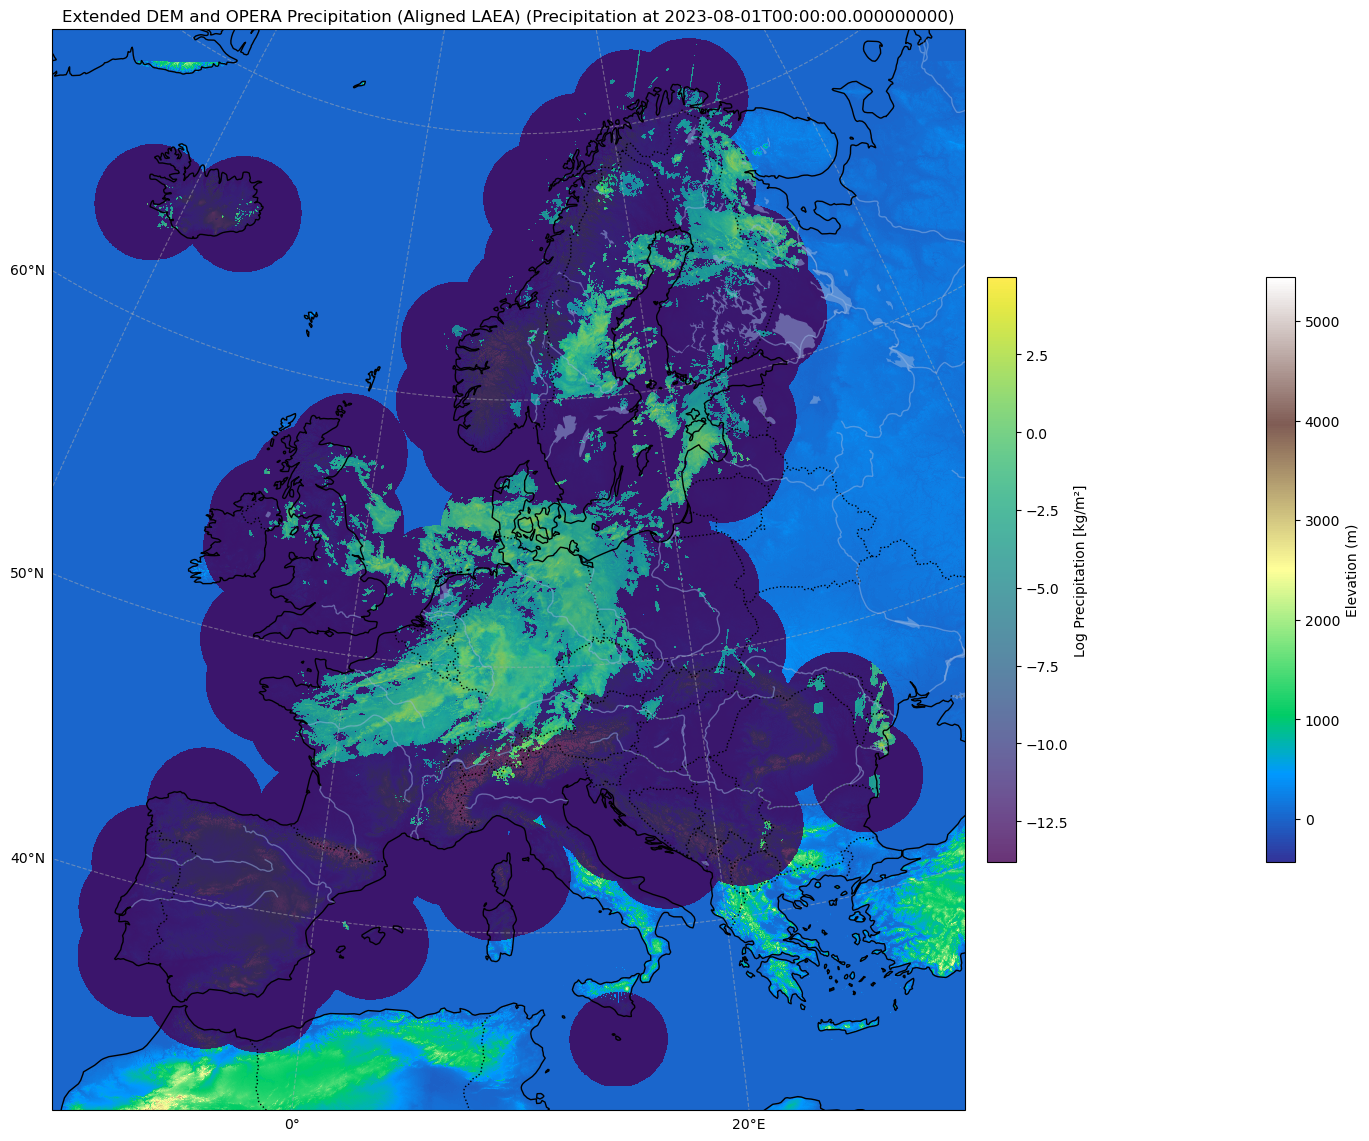

In [60]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

def plot_aligned_dem_and_precipitation(reproj_dem_path, precip_ds, precip_time_index=0, plot_title="Aligned DEM and Precipitation"):
    """
    Loads a reprojected DEM and precipitation data, then plots them together
    in their shared custom LAEA projection.

    Args:
        reproj_dem_path (str): Path to the reprojected DEM NetCDF file
                               (expected in OPERA's custom LAEA projection).
        precip_data_path (str): Path to the original OPERA precipitation data NetCDF file
                                (expected in its custom LAEA projection).
        precip_time_index (int): Index of the time step to plot for precipitation.
        plot_title (str): Title for the overall plot.
    """

    # --- Define the shared custom LAEA CRS for Cartopy plotting ---
    # This comes from your precipitation data's proj4 string:
    # "+proj=laea +lat_0=55 +lon_0=10 +x_0=1950000 +y_0=-2100000 +units=m +datum=WGS84 +no_defs"
    opera_laea_cartopy_crs = ccrs.LambertAzimuthalEqualArea(
        central_latitude=55.0,
        central_longitude=10.0,
        false_easting=1950000.0,
        false_northing=-2100000.0,
        globe=ccrs.Globe(datum='WGS84', ellipse='WGS84')
    )

    # Define the proj4 string for rioxarray's internal CRS handling
    # (used if we need to explicitly write CRS, though it should be embedded)
    opera_laea_proj_str = "+proj=laea +lat_0=55 +lon_0=10 +x_0=1950000 +y_0=-2100000 +units=m +datum=WGS84 +no_defs"


    print(f"Loading reprojected DEM from: {reproj_dem_path}")

    # --- Load and prepare Data ---
    try:
        # Load the reprojected DEM DataArray
        reproj_dem_da = xr.open_dataarray(reproj_dem_path)
        # Ensure spatial dims and CRS are recognized by rioxarray
        reproj_dem_da = reproj_dem_da.rio.set_spatial_dims(x_dim="x", y_dim="y").rio.write_crs(reproj_dem_da.rio.crs, inplace=True)
        # Ensure Y-axis is north-up (important for plotting if not already)
        if reproj_dem_da.y.values[0] > reproj_dem_da.y.values[-1]:
            reproj_dem_da = reproj_dem_da.isel(y=slice(None, None, -1))

        # Load precipitation data
        precip_data_var = precip_ds['TOT_PREC'].isel(time=precip_time_index)
        precip_data_var = precip_data_var.rio.set_spatial_dims(x_dim="x", y_dim="y").rio.write_crs(opera_laea_proj_str, inplace=True)
        # Ensure Y-axis is north-up
        if precip_data_var.y.values[0] > precip_data_var.y.values[-1]:
            precip_data_var = precip_data_var.isel(y=slice(None, None, -1))

        print(f"Reprojected DEM CRS: {reproj_dem_da.rio.crs}")
        print(f"Precipitation Data CRS: {precip_data_var.rio.crs}")
        print(f"Reprojected DEM bounds: {reproj_dem_da.rio.bounds()}")
        print(f"Precipitation bounds: {precip_data_var.rio.bounds()}")

        # Take log of precipitation data for better visualization range
        precip_log_data = np.log(precip_data_var.values + 1e-6) # Add small value to avoid log(0)

    except FileNotFoundError as e:
        print(f"Error: One of the files not found. {e}")
        return
    except Exception as e:
        print(f"An error occurred during data loading or preparation: {e}")
        return

    # --- Plotting ---
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(1, 1, 1, projection=opera_laea_cartopy_crs)

    # Plot reprojected DEM
    dem_im = ax.pcolormesh(reproj_dem_da.x.values, reproj_dem_da.y.values, reproj_dem_da.values,
                           transform=opera_laea_cartopy_crs, # Data is already in this CRS
                           cmap='terrain', shading='auto',
                           zorder=1) # Plot DEM first

    cbar_dem = plt.colorbar(dem_im, ax=ax, shrink=0.5, pad=0.08)
    cbar_dem.set_label('Elevation (m)')

    # Plot precipitation
    precip_im = ax.pcolormesh(precip_data_var.x.values, precip_data_var.y.values, precip_log_data,
                              transform=opera_laea_cartopy_crs, # Data is already in this CRS
                              cmap='viridis', shading='auto',
                              alpha=0.8, # Make it slightly transparent
                              zorder=2) # Plot precipitation on top

    cbar_precip = plt.colorbar(precip_im, ax=ax, shrink=0.5, pad=0.02)
    cbar_precip.set_label("Log Precipitation [kg/m²]")

    # --- Add Map Features ---
    ax.coastlines(resolution='50m', zorder=3)
    ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=3)
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none', zorder=0) # Base land, no fill
    ax.add_feature(cfeature.OCEAN, zorder=0) # Base ocean, no fill
    ax.add_feature(cfeature.LAKES, alpha=0.5, zorder=3)
    ax.add_feature(cfeature.RIVERS, alpha=0.5, zorder=3)

    # Set the plot extent to the combined extent for a clear view
    # Since they should be aligned, we can use precip's extent or a union
    minx, miny, maxx, maxy = precip_data_var.rio.bounds()
    ax.set_extent([minx, maxx, miny-100000, maxy], crs=opera_laea_cartopy_crs)


    # Add gridlines
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    ax.set_title(f"{plot_title} (Precipitation at {precip_ds['time'].to_numpy()[precip_time_index]})")

    plt.tight_layout()
    plt.show()


# --- Example Usage ---
# Paths (ensure these match your file structure)
dem_original_dir = '/work/FAC/FGSE/IDYST/tbeucler/downscaling/fquareng/data/OPERA/dem'
reprojected_dem_filename = 'reproj_OPERA_1km_europe_dem.nc'
reproj_dem_file_path = os.path.join(dem_original_dir, reprojected_dem_filename)

precip_data_file_path = '/work/FAC/FGSE/IDYST/tbeucler/downscaling/fquareng/data/OPERA/TOT_PREC/20210818.nc' # <--- IMPORTANT: UPDATE THIS TO YOUR OPERA PRECIPITATION DATA PATH!

plot_aligned_dem_and_precipitation(
    reproj_dem_path=reproj_dem_file_path,
    precip_ds=precip_ds,
    precip_time_index=0, # Plot the first time step
    plot_title='Extended DEM and OPERA Precipitation (Aligned LAEA)'
)

# 1. Extract data and generate dataset

In [6]:
opera_patches = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/fquareng/data/OPERA/patches"

files = sorted(f for f in os.listdir(opera_patches) if f.endswith(".npz"))

inputs = []
for filename in tqdm(files[:1000]):
    file_path = os.path.join(opera_patches, filename)
    with np.load(file_path) as data:
        inputs.append(data['patches'])
precip = np.concatenate(inputs, axis=0)

  0%|          | 1/1000 [00:00<01:54,  8.73it/s]

100%|██████████| 1000/1000 [00:43<00:00, 22.89it/s]


In [7]:
thresholds = np.arange(np.min(precip), np.max(precip))
print(thresholds)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149.]


In [8]:
# # Flatten the precip array to 1D if needed (remove NaNs or masked values if present)
# flat_precip = precip[~np.isnan(precip)].flatten()

# # Choose how many quantiles you want (e.g., 20 quantile thresholds from 0 to 1)
# quantile_levels = np.linspace(0, 1, num=21)  # 0%, 5%, ..., 100%
# thresholds = np.quantile(flat_precip, quantile_levels)

# print("Quantile-based thresholds:", thresholds)

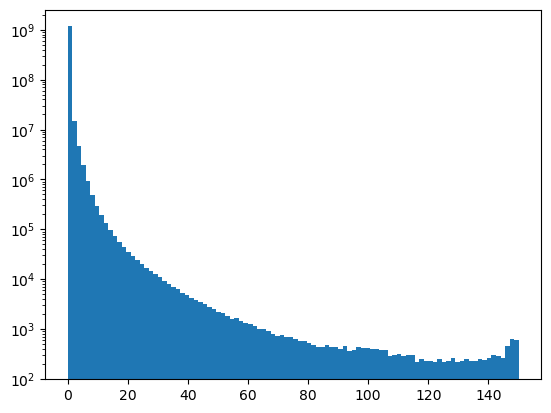

In [9]:
plt.hist(precip.flatten(), bins=100)
plt.yscale("log")
plt.show()

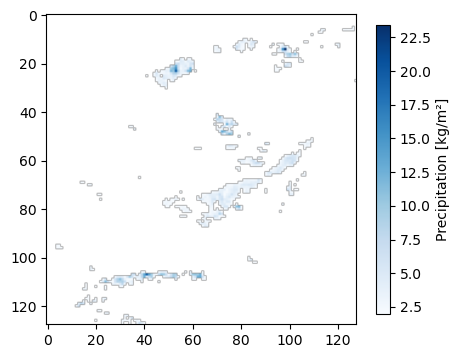

In [18]:
i = 750  # strong event
# i = 700  # weak event
# i = 0    # empty 
prec = precip[i][::-1, :]
masked_prec = np.ma.masked_where(prec < 2, prec)

_, ax = plt.subplots(figsize=(5, 5)) # PlateCarree, Mercator
im = ax.imshow(masked_prec, cmap='Blues')
cbar = plt.colorbar(im, ax=ax, shrink=.75, pad=.05)
cbar.set_label("Precipitation [kg/m²]")
# plt.tight_layout()
plt.show()

# 2. Compute gamma

In [11]:
def compute_A_P_CC(prec, threshold=2):
    # Masked prec
    mask = prec >= threshold
    
    # Area
    pixel_size_km = 1.0  # example: 1 km² per pixel
    area_km2 = mask.sum() * pixel_size_km**2
    # print(f"Area above {threshold} kg/m²: {area_km2:.2f} km²")

    # Perimeter
    contours = measure.find_contours(mask.astype(float), 0.5)
    perimeter_pixels = sum(np.linalg.norm(np.diff(contour, axis=0), axis=1).sum() for contour in contours)
    perimeter_km = perimeter_pixels * pixel_size_km
    # print(f"Perimeter above {threshold} kg/m²: {perimeter_km:.2f} km")

    # #CC
    # 4-connected
    structure=[[0,1,0],
               [1,1,1],
               [0,1,0]]
    # 8-connected
#     structure = np.ones((3, 3))
    labeled_array, num_features = label(mask, structure=structure)  
    # print(f"Number of connected components (precip ≥ {threshold} kg/m²): {num_features}")

    return area_km2, perimeter_km, num_features, labeled_array

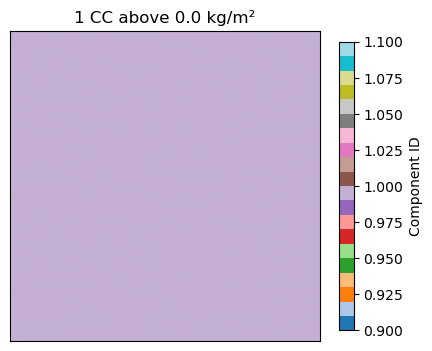

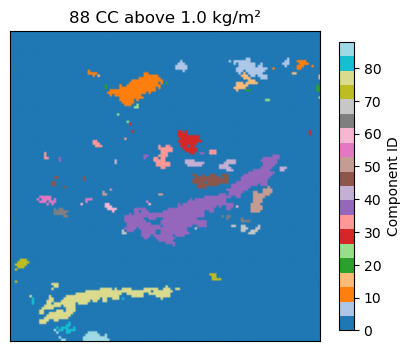

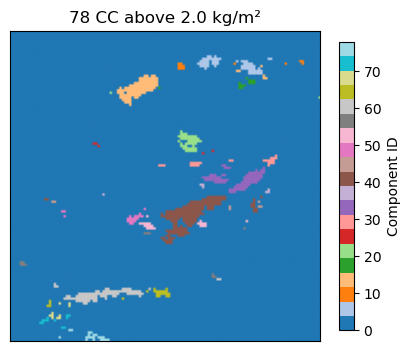

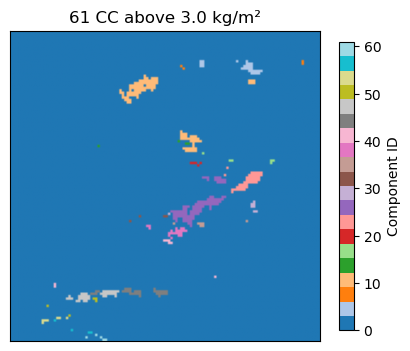

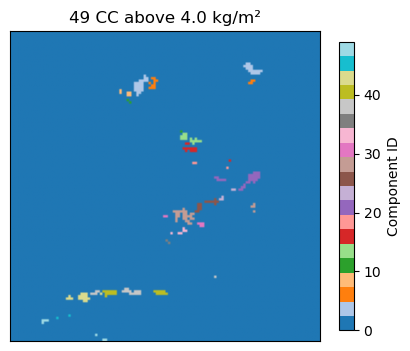

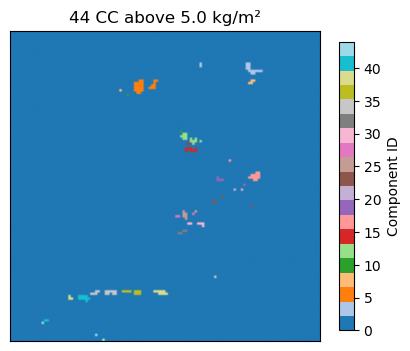

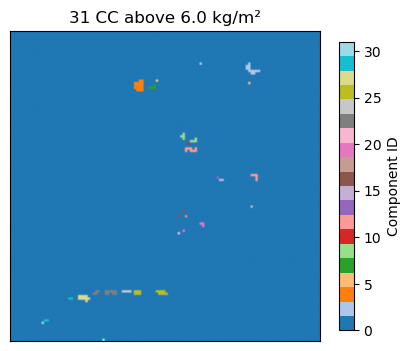

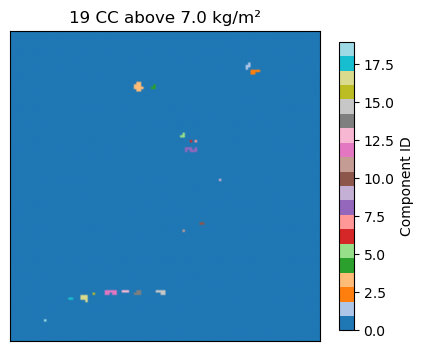

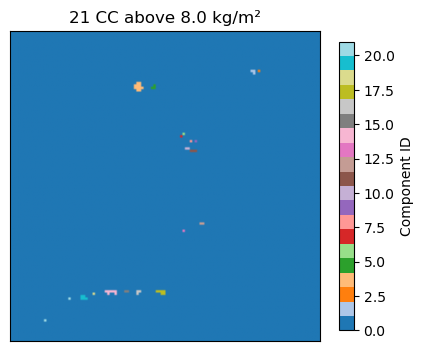

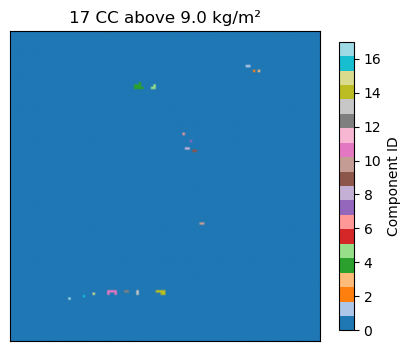

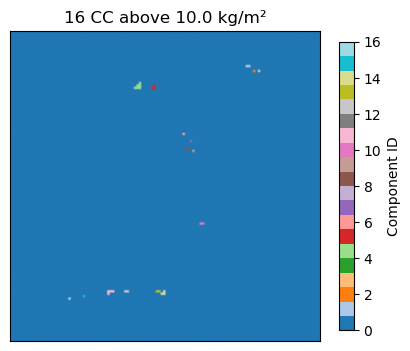

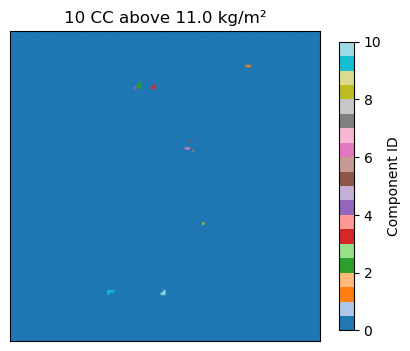

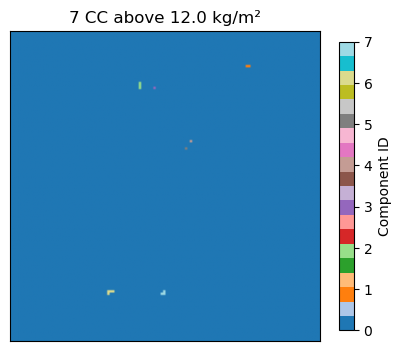

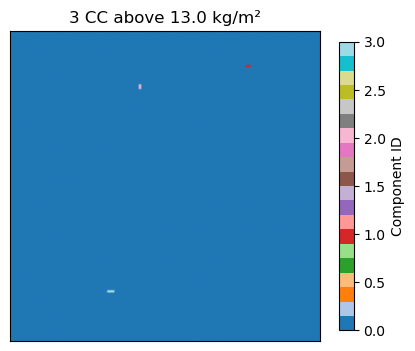

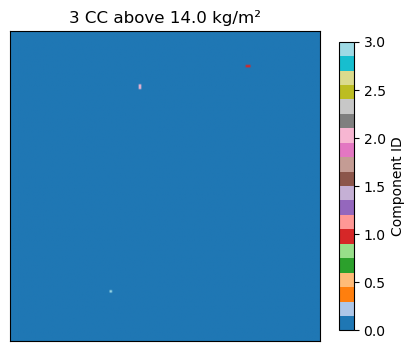

In [20]:
gamma = np.zeros((len(thresholds), 3))
for i, t in enumerate(thresholds):
    area_km2, perimeter_km, num_features, labeled_array = compute_A_P_CC(prec, t)
    gamma[i] = [area_km2, perimeter_km, num_features]
    if i in range(15):
        plt.figure(figsize=(5, 5))
        plt.imshow(labeled_array, cmap="tab20")
        plt.colorbar(label='Component ID', shrink=.75, pad=.05)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'{num_features} CC above {t} kg/m²')
        plt.show()

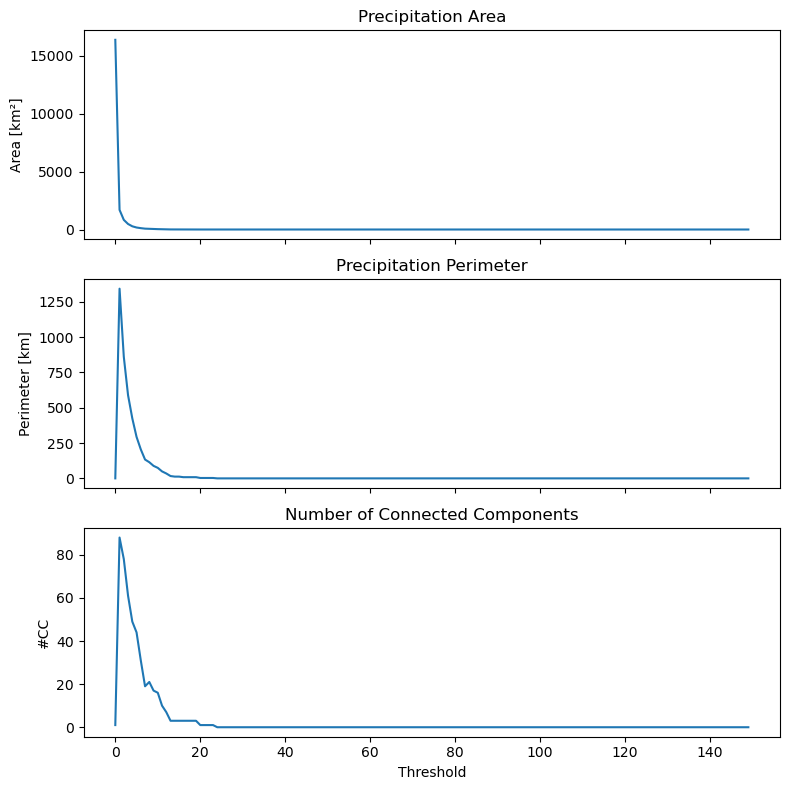

In [22]:
# Assume gamma is a list or array with 3 elements: [area_series, perimeter_series, cc_series]
area_series = gamma[:, 0]
perimeter_series = gamma[:, 1]
cc_series = gamma[:, 2]

fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

axs[0].plot(thresholds, area_series)
axs[0].set_ylabel("Area [km²]")
#axs[0].set_yscale("log")
axs[0].set_title("Precipitation Area")

axs[1].plot(thresholds, perimeter_series)
axs[1].set_ylabel("Perimeter [km]")
#axs[1].set_yscale("log")
axs[1].set_title("Precipitation Perimeter")

axs[2].plot(thresholds, cc_series)
axs[2].set_ylabel("#CC")
#axs[2].set_yscale("log")
axs[2].set_xlabel("Threshold")
axs[2].set_title("Number of Connected Components")

plt.tight_layout()
plt.show()

In [ ]:
gamma 

array([[1.63840000e+04, 0.00000000e+00, 1.00000000e+00],
       [1.69600000e+03, 1.34210173e+03, 8.80000000e+01],
       [8.33000000e+02, 8.60259018e+02, 7.80000000e+01],
       [4.78000000e+02, 5.88553391e+02, 6.10000000e+01],
       [2.78000000e+02, 4.24629509e+02, 4.90000000e+01],
       [1.73000000e+02, 2.93605122e+02, 4.40000000e+01],
       [1.18000000e+02, 2.05036580e+02, 3.10000000e+01],
       [7.50000000e+01, 1.33195959e+02, 1.90000000e+01],
       [5.80000000e+01, 1.14367532e+02, 2.10000000e+01],
       [4.20000000e+01, 8.85685425e+01, 1.70000000e+01],
       [3.30000000e+01, 7.43259018e+01, 1.60000000e+01],
       [2.20000000e+01, 4.93553391e+01, 1.00000000e+01],
       [1.50000000e+01, 3.46274170e+01, 7.00000000e+00],
       [7.00000000e+00, 1.64852814e+01, 3.00000000e+00],
       [5.00000000e+00, 1.24852814e+01, 3.00000000e+00],
       [5.00000000e+00, 1.24852814e+01, 3.00000000e+00],
       [3.00000000e+00, 8.48528137e+00, 3.00000000e+00],
       [3.00000000e+00, 8.48528